In [1]:
from DiffeoOT import *
from utils import *
import torch
import time 
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [2]:
m=64

x = torch.linspace(-1,1,m)
y = torch.linspace(-1,1,m)
grid = torch.zeros((1,m,m,2)).to(dtype=torchdtype, device=torchdeviceId)
for i in range(0,m):
        for j in range(0,m):
            grid[0,i,j,0]= x[i]
            grid[0,i,j,1]= y[j]

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:4003: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


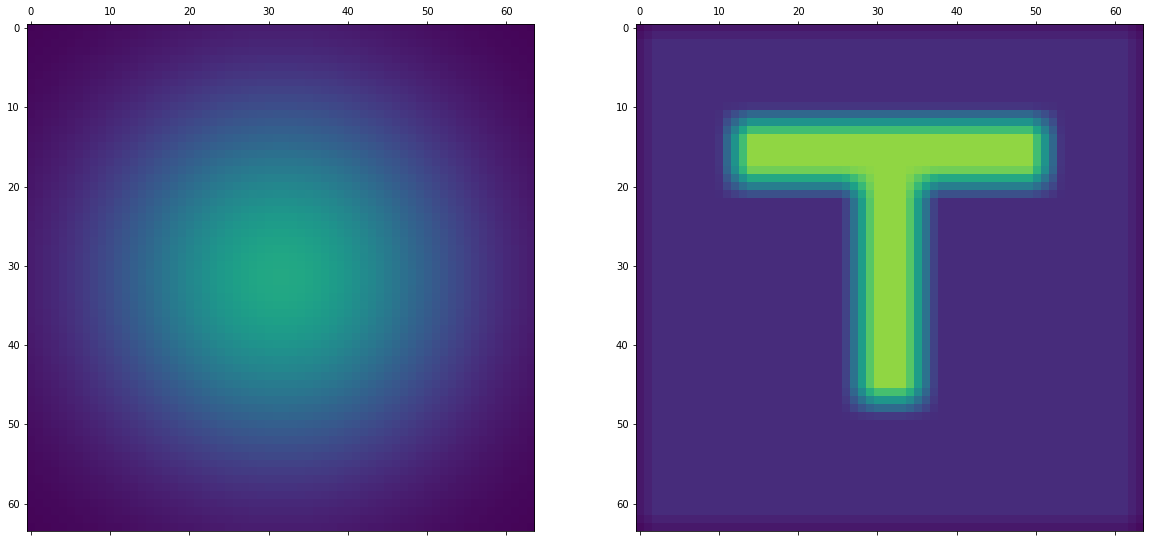

In [3]:
mu_2 = load_dist("T.png",grid)
G1=torch.Tensor([[2,0],[0,2]]).to(dtype=torchdtype, device=torchdeviceId)
mu_1 = gaussian(0,0,G1,grid)
plot_pair(mu_1,mu_2)

In [4]:
params=[]
params+=[{'T':6, 'match_coeff':1000, 'path_coeff':1}]

In [5]:
#def L(vf):
#    weight = torch.Tensor([[[[-1,-1,-1],[-1,8,-1],[-1,-1,-1]]]]).to(dtype=torchdtype, device=torchdeviceId)
#    out = tnn.conv2d(vf, weight.repeat(2,1,1,1), bias=None,groups=2, stride=1, padding='same') 
#    out = tnn.conv2d(out, weight.repeat(2,1,1,1), bias=None,groups=2, stride=1, padding='same') 
#    out = tnn.conv2d(out, weight.repeat(2,1,1,1), bias=None,groups=2, stride=1, padding='same') 
#    return out

In [6]:
def inner_prod(X,source,p,grid):
    pm=p[0,0]
    pX= pm*X.transpose(0,2)
    return ((pX**2).sum(dim=0)/(pm)).sum()  

In [7]:
start =time.time()
vecs = DiffeoOT_multires(mu_1,mu_2,grid,params,inner_prod)
print(time.time()-start)
pl_pathlength = path_length(mu_1,vecs,grid,inner_prod)
print(pl_pathlength)
N=vecs.shape[0]

123.29199981689453
[1.10534435 1.00641988 0.97342359 0.97633785 0.97741803]


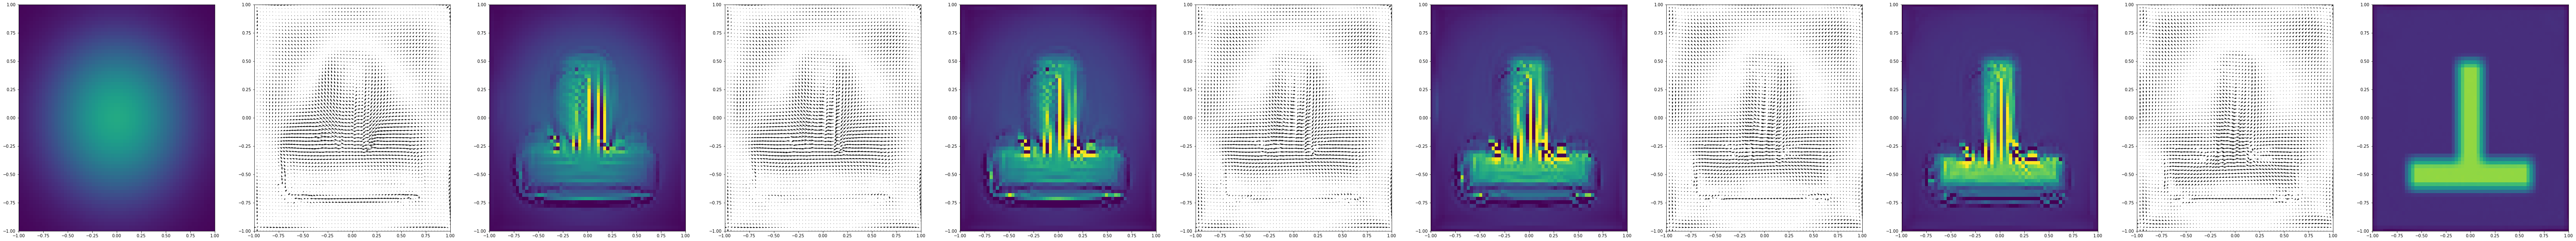

In [8]:
ls = make_and_plot_sequence(mu_1,mu_2,vecs, grid)
save_gif(mu_1,mu_2,ls)